In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *

# from fastai.transforms import import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = 'SpaceNet_Roads_Sample/'

In [3]:
dirs = os.listdir(PATH)
dirs.sort()

In [4]:
VEGAS, PARIS, SHANG, KHART = [PATH + directory + '/' for directory in dirs]

In [5]:
model = resnet34(True)

Delete top layers:

In [6]:
model = nn.Sequential(*children(model)[:-2],
                      nn.Conv2d(512, 1, 3, padding=1), # 1 output bc looking for 1 class
                      nn.AdaptiveAvgPool2d(1), Flatten(), # 2 layers here (pool & flatn)
                      nn.LogSoftmax())

Data

In [7]:
vegas_csv_path = VEGAS + 'summaryData/' + 'AOI_2_Vegas_Roads_Sample.csv'
vegas_train_folder = VEGAS + 'RGB-PanSharpen'

In [8]:
VEGAS

'SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/'

In [9]:
os.listdir('SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/')

['MUL',
 'tmp',
 'RGB-PanSharpen',
 'geojson',
 'models',
 'PAN',
 'train',
 'summaryData',
 'MUL-PanSharpen']

In [10]:
os.listdir(VEGAS+'RGB-PanSharpen')

['RGB-PanSharpen_AOI_2_Vegas_img699.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img230.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1454.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img517.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img734.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1521.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img767.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img408.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img794.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1539.tif']

In [23]:
# os.mkdir(VEGAS+'train/')
# os.mkdir(VEGAS+'train/one')

files copied to $VEGAS/train/one in terminal

In [11]:
sz = 224
bs = 64
tfms = tfms_from_model(model, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(VEGAS, tfms=tfms, bs=bs, trn_name='train',
                                      val_name='train')

In [12]:
learner = ConvLearner.from_model_data(model, data)

In [13]:
learner.freeze_to(-4)

In [14]:
model[-1].trainable, model[-4].trainable

(True, True)

In [15]:
model[-4]

Conv2d (512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [16]:
learner.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy            
    0      0.0        0.0        1.0       



[0.0, 1.0]

In [17]:
learner.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy            
    0      0.0        0.0        1.0       



[0.0, 1.0]

In [18]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [19]:
x,y = next(iter(data.val_dl))
x,y = x[None, 1], y[None, 1]

vx = Variable(x.cuda(), requires_grad=True)

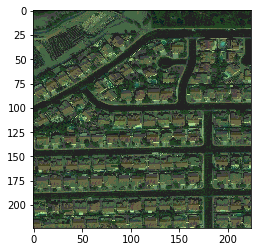

In [20]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(35*dx);

In [21]:
sf = SaveFeatures(model[-4])
py = model(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([1.], dtype=float32)

In [22]:
feat = np.maximum(0, sf.features[0])
feat.shape

(1, 7, 7)

In [23]:
f2 = np.dot(np.rollaxis(feat, 0, 3), py)
f2 -= f2.min()
f2 /= f2.max()
f2

array([[0.10148, 0.24985, 0.37335, 0.36038, 0.14824, 0.12595, 0.05218],
       [0.79095, 0.84846, 0.61209, 0.59915, 0.67495, 0.98675, 0.55943],
       [0.578  , 0.60002, 0.64019, 0.84933, 0.80616, 0.94447, 0.39363],
       [0.71307, 0.46944, 0.43284, 0.59028, 0.64952, 0.79083, 0.29587],
       [0.78899, 0.4611 , 0.55337, 0.6318 , 0.58597, 0.66772, 0.13225],
       [0.88458, 0.39336, 0.44795, 0.37963, 0.36341, 0.36803, 0.     ],
       [1.     , 0.68768, 0.62122, 0.57536, 0.70335, 0.61526, 0.13166]], dtype=float32)

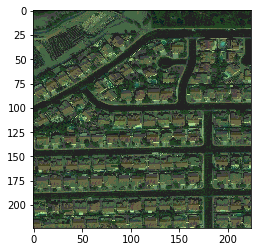

In [24]:
plt.imshow(dx*35)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


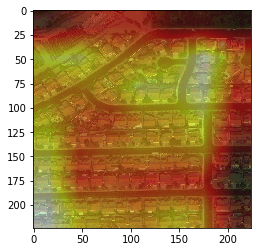

In [25]:
plt.imshow(dx*35)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

Max -- Coordinate for Road Node Script:

In [29]:
np.argpartition(f2, -4)[-4:]

array([[1, 6, 2, 3, 4, 5, 0],
       [6, 1, 2, 4, 3, 5, 0],
       [4, 6, 5, 3, 1, 2, 0],
       [6, 3, 5, 2, 1, 4, 0]])

In [30]:
np.argmax(f2[0])

2

In [31]:
f2[0]

array([0.10148, 0.24985, 0.37335, 0.36038, 0.14824, 0.12595, 0.05218], dtype=float32)

In [32]:
f2

array([[0.10148, 0.24985, 0.37335, 0.36038, 0.14824, 0.12595, 0.05218],
       [0.79095, 0.84846, 0.61209, 0.59915, 0.67495, 0.98675, 0.55943],
       [0.578  , 0.60002, 0.64019, 0.84933, 0.80616, 0.94447, 0.39363],
       [0.71307, 0.46944, 0.43284, 0.59028, 0.64952, 0.79083, 0.29587],
       [0.78899, 0.4611 , 0.55337, 0.6318 , 0.58597, 0.66772, 0.13225],
       [0.88458, 0.39336, 0.44795, 0.37963, 0.36341, 0.36803, 0.     ],
       [1.     , 0.68768, 0.62122, 0.57536, 0.70335, 0.61526, 0.13166]], dtype=float32)

In [26]:
dx.shape

(224, 224, 3)

In [49]:
ls $VEGAS/summaryData

AOI_2_Vegas_Roads_Sample.csv


In [51]:
df = pd.read_csv(VEGAS + 'summaryData/' + 'AOI_2_Vegas_Roads_Sample.csv')

In [52]:
df.head()

,ImageId,WKT_Pix
0,AOI_2_Vegas_img408,"LINESTRING (103.17 0.00, 106.45 54.10, 114.10 ..."
1,AOI_2_Vegas_img408,"LINESTRING (121.11 1300.00, 118.55 1001.51, 11..."
2,AOI_2_Vegas_img408,"LINESTRING (16.98 51.97, 106.45 54.10)"
3,AOI_2_Vegas_img408,"LINESTRING (118.55 1001.51, 224.85 1000.57, 41..."
4,AOI_2_Vegas_img408,"LINESTRING (143.65 284.74, 191.51 277.93, 440...."


In [ ]:
data = ImageClassifierData.from_csv(vegas_csv_path, )

In [55]:
ls $VEGAS

geojson/  MUL/  MUL-PanSharpen/  PAN/  RGB-PanSharpen/  summaryData/


In [66]:
ls $VEGAS/RGB-PanSharpen/

RGB-PanSharpen_AOI_2_Vegas_img1454.tif*  RGB-PanSharpen_AOI_2_Vegas_img517.tif*
RGB-PanSharpen_AOI_2_Vegas_img1521.tif*  RGB-PanSharpen_AOI_2_Vegas_img699.tif*
RGB-PanSharpen_AOI_2_Vegas_img1539.tif*  RGB-PanSharpen_AOI_2_Vegas_img734.tif*
RGB-PanSharpen_AOI_2_Vegas_img230.tif*   RGB-PanSharpen_AOI_2_Vegas_img767.tif*
RGB-PanSharpen_AOI_2_Vegas_img408.tif*   RGB-PanSharpen_AOI_2_Vegas_img794.tif*


In [67]:
ls $VEGAS/MUL/

MUL_AOI_2_Vegas_img1454.tif*  MUL_AOI_2_Vegas_img517.tif*
MUL_AOI_2_Vegas_img1521.tif*  MUL_AOI_2_Vegas_img699.tif*
MUL_AOI_2_Vegas_img1539.tif*  MUL_AOI_2_Vegas_img734.tif*
MUL_AOI_2_Vegas_img230.tif*   MUL_AOI_2_Vegas_img767.tif*
MUL_AOI_2_Vegas_img408.tif*   MUL_AOI_2_Vegas_img794.tif*


In [72]:
ls $VEGAS/PAN

PAN_AOI_2_Vegas_img1454.tif*  PAN_AOI_2_Vegas_img517.tif*
PAN_AOI_2_Vegas_img1521.tif*  PAN_AOI_2_Vegas_img699.tif*
PAN_AOI_2_Vegas_img1539.tif*  PAN_AOI_2_Vegas_img734.tif*
PAN_AOI_2_Vegas_img230.tif*   PAN_AOI_2_Vegas_img767.tif*
PAN_AOI_2_Vegas_img408.tif*   PAN_AOI_2_Vegas_img794.tif*


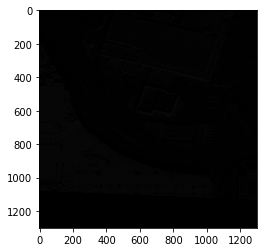

In [73]:
# img = cv2.imread(f'{VEGAS}RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1521.tif')
# img = cv2.imread(f'{VEGAS}MUL/MUL_AOI_2_Vegas_img794.tif')
img = cv2.imread(f'{VEGAS}PAN/PAN_AOI_2_Vegas_img1454.tif')
plt.imshow(img)

In [79]:
os.listdir('SpaceNet_Roads_Sample')

['AOI_5_Khartoum_Roads_Sample',
 'AOI_2_Vegas_Roads_Sample',
 'AOI_4_Shanghai_Roads_Sample',
 'AOI_3_Paris_Roads_Sample']

In [78]:
os.listdir('SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample')

['MUL', 'RGB-PanSharpen', 'geojson', 'PAN', 'summaryData', 'MUL-PanSharpen']

In [84]:
os.listdir(PARIS), os.listdir(PARIS + os.listdir(PARIS)[0])

(['MUL', 'RGB-PanSharpen', 'geojson', 'PAN', 'summaryData', 'MUL-PanSharpen'],
 ['MUL_AOI_3_Paris_img432.tif',
  'MUL_AOI_3_Paris_img38.tif',
  'MUL_AOI_3_Paris_img406.tif',
  'MUL_AOI_3_Paris_img340.tif',
  'MUL_AOI_3_Paris_img235.tif',
  'MUL_AOI_3_Paris_img307.tif',
  'MUL_AOI_3_Paris_img489.tif',
  'MUL_AOI_3_Paris_img28.tif',
  'MUL_AOI_3_Paris_img496.tif',
  'MUL_AOI_3_Paris_img84.tif'])

In [101]:
img = cv2.imread(f'{PARIS}/MUL/MUL_AOI_3_Paris_img432.tif')
# img *= 256
plt.imshow(img)

TypeError: 'dtype' is an invalid keyword argument for this function

In [100]:
img.dtype

dtype('uint8')

In [107]:
img *= 100; img

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [200, 100, 100],
        [200, 100, 100],
        [200, 200, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [200, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       ...,

       [[200, 100, 100],
        [200, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[200, 100, 100],
        [200, 100, 100],
        [200, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [200, 100, 100],
        [200, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]

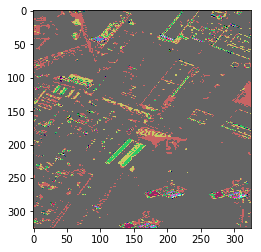

In [108]:
plt.imshow(img)

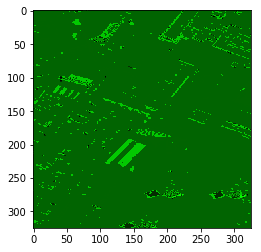

In [135]:
img = cv2.imread(f'{PARIS}/MUL/MUL_AOI_3_Paris_img432.tif')
img[:,:,1] *= 100
plt.imshow(img)

In [129]:
img.shape

(325, 325, 3)

In [136]:
os.listdir(PARIS), os.listdir(PARIS + os.listdir(PARIS)[1])

(['MUL', 'RGB-PanSharpen', 'geojson', 'PAN', 'summaryData', 'MUL-PanSharpen'],
 ['RGB-PanSharpen_AOI_3_Paris_img84.tif',
  'RGB-PanSharpen_AOI_3_Paris_img235.tif',
  'RGB-PanSharpen_AOI_3_Paris_img340.tif',
  'RGB-PanSharpen_AOI_3_Paris_img406.tif',
  'RGB-PanSharpen_AOI_3_Paris_img432.tif',
  'RGB-PanSharpen_AOI_3_Paris_img496.tif',
  'RGB-PanSharpen_AOI_3_Paris_img38.tif',
  'RGB-PanSharpen_AOI_3_Paris_img307.tif',
  'RGB-PanSharpen_AOI_3_Paris_img489.tif',
  'RGB-PanSharpen_AOI_3_Paris_img28.tif'])

In [144]:
os.listdir(PARIS)[1]+'/'+os.listdir(PARIS + os.listdir(PARIS)[1])[0]

'RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img84.tif'

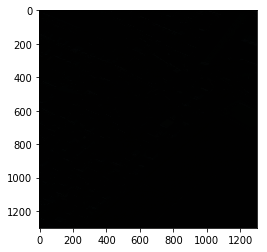

In [165]:
# img = cv2.imread(f'{PARIS}/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img84.tif')
img = cv2.imread(f'{PARIS}/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img406.tif')
# img *= 80

# for i,e in enumerate(img):
#     img[i] = 255 * e / img.max()

plt.imshow(img)